# 0. 프로젝트 기획

딥러닝
자연어처리(NLP)
감성 분석
다중 감성 분석

데이터 : AIhub 감성 대화 말뭉치

In [7]:
# 시각화 시 한글 폰트 설정

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [19]:
!pip install squarify

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Mecab을 포함한 konlpy 설치

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt

# 1. 데이터 전처리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [211]:
train = pd.read_excel("/content/drive/MyDrive/코드스테이츠/Section4/Project/data/감성대화말뭉치(최종데이터)_Training.xlsx")

In [212]:
val = pd.read_excel("/content/drive/MyDrive/코드스테이츠/Section4/Project/data/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [213]:
train.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [214]:
val.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN
3,169,청년,남성,"진로, 취업, 직장",해당없음,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,팀장님이 부탁하신 업무를 잘못 처리하셔서 많이 당황하시고 놀라셨겠어요.,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.,마음이 많이 안 좋으시겠어요. 지금 상황을 타개할 수 있는 가장 좋은 방안이 있을까요?,우선 잘못된 부분을 솔직하게 말씀드리고 수정하기 위해서 최선을 다해봐야겠어.,잘못된 부분을 잘 수정해서 좋은 결과가 있었으면 좋겠어요.,NaN,NaN
4,38435,중년,여성,"재정, 은퇴, 노후준비",해당없음,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,많이 화가 나시겠어요.,어떻게 그럴 수가 있지? 너무 화가 나.,어떻게 하면 지금의 감정을 추스를 수 있을까요?,나도 변호사를 고용해서 한번 얘기해보려고 해.,자녀분들이랑 함께 하며 슬픔을 극복하시길 바라요.,NaN,NaN


In [215]:
# input을 '사람문장1'(감정이 들어간 문장), output을 '감정_대분류'로 설정

train = train[['사람문장1', '감정_대분류']]
val = val[['사람문장1', '감정_대분류']]

In [216]:
# NaN값 유무 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40879 entries, 0 to 40878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   40879 non-null  object
 1   감정_대분류  40879 non-null  object
dtypes: object(2)
memory usage: 638.9+ KB


In [217]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   5130 non-null   object
 1   감정_대분류  5130 non-null   object
dtypes: object(2)
memory usage: 80.3+ KB


In [219]:
print(train['감정_대분류'].unique())
print(val['감정_대분류'].unique())
# train set에 '불안 ' 및 '기쁨 ' 과 같이 공백이 껴있는 데이터 발견

['기쁨' '불안' '당황' '슬픔' '분노' '상처' '불안 ' '기쁨 ']
['분노' '슬픔' '불안' '당황' '상처' '기쁨']


In [220]:
train['감정_대분류'] = train['감정_대분류'].apply(lambda x : x.rstrip())

In [222]:
train.columns = ['sentence', 'label']
val.columns = ['sentence', 'label']

In [224]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

train['label'] = enc.fit_transform(train['label'])
val['label'] = enc.transform(val['label'])

# """
# 0 : 기쁨
# 1 : 당황
# 2 : 분노
# 3 : 불안
# 4 : 상처
# 5 : 슬픔
# """

# 2. 텍스트 전처리
- regex 전처리
- 형태소 분석기를 이용한 token화
- 불용어 사전을 이용한 불용어 제거

## 2-1. regex 전처리

In [228]:
import re

train['sentence'] = train['sentence'].apply(lambda x : re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))
val['sentence'] = val['sentence'].apply(lambda x : re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))

## 2-2. Tokenizer(형태소 분석기 이용)

In [ ]:
# Mecab을 포함한 konlpy 설치

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [231]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt

han = Hannanum()
kkma = Kkma()
komo = Komoran()
mecab = Mecab()
okt = Okt()

In [ ]:
# 형태소 분석기 별 형태소 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab]:
    print(tokenizer.morphs(train['sentence'][0]))
print(okt.morphs(train['sentence'][0], stem=True)) # okt의 경우 stemming 기능 제공

In [ ]:
# 형태소 분석기 별 품사 태깅 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab, okt]:
    print(tokenizer.pos(train['sentence'][0]))

[('아내', 'N'), ('가', 'J'), ('드디어', 'M'), ('출산', 'N'), ('하', 'X'), ('게', 'E'), ('되', 'P'), ('어서', 'E'), ('정말', 'M'), ('신', 'N'), ('이', 'J'), ('나', 'N')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'ECD'), ('되', 'VV'), ('어서', 'ECD'), ('정말', 'MAG'), ('신이', 'NNG'), ('나', 'NNG')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('되', 'VV'), ('어서', 'EC'), ('정말', 'MAG'), ('신이', 'NNP'), ('나', 'NP')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('되', 'VV'), ('어서', 'EC'), ('정말', 'MAG'), ('신', 'NNG'), ('이', 'JKS'), ('나', 'VV+EC')]
[('아내', 'Noun'), ('가', 'Josa'), ('드디어', 'Adverb'), ('출산', 'Noun'), ('하게', 'Verb'), ('되어서', 'Verb'), ('정말', 'Noun'), ('신', 'Noun'), ('이', 'Josa'), ('나', 'Noun')]


In [ ]:
# 형태소 분석기 별 명사 태깅 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab, okt]:
    print(tokenizer.nouns(train['sentence'][0]))

['아내', '출산', '신', '나']
['아내', '출산', '신이', '나']
['아내', '출산', '신이']
['아내', '출산', '신']
['아내', '출산', '정말', '신', '나']


In [232]:
# Mecab 을 이요하여 형태소 단위로 토큰화 결정

train['tokens'] = train['sentence'].apply(lambda x : mecab.morphs(x))
val['tokens'] = val['sentence'].apply(lambda x : mecab.morphs(x))

In [233]:
train.head()

,sentence,label,tokens
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 가, 드디어, 출산, 하, 게, 되, 어서, 정말, 신, 이, 나]"
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 때문, 에, 먹, 어야, 할, 약, 이, 열, 가지, 가, ..."
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 에, 올라오, 니, 중학교, 때, 보다, 수업, 이, 갑자기, 어려워져..."
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 이, 돼서, 받, 게, 된, 첫, 월급, 으로, 온, 가족, 이, 외식,..."
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 을, 드디어, 다, 갚, 게, 되, 어서, 이제야, 안도감, 이, 들, 어]"


## 2-3. 불용어 제거

In [234]:
stop_words_1 = pd.read_table('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/한국어불용어100.txt', header=None) # https://bab2min.tistory.com/544#google_vignette

In [235]:
stop_words_2 = pd.read_csv('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/한국어불용어(rank_nl_stopwords_korean).txt', header=None) # https://www.ranks.nl/stopwords/korean

In [236]:
# 실제 단어만 추출

stop_words_1 = stop_words_1[[0]]

In [237]:
stop_words_1.head()

,0
0,이
1,있
2,하
3,것
4,들


In [238]:
stop_words_2.head()

,0
0,아
1,휴
2,아이구
3,아이쿠
4,아이고


In [239]:
stop_words = pd.concat([stop_words_1, stop_words_2])
stop_words.drop_duplicates(subset=[0], inplace=True)
stop_words.reset_index(drop=True, inplace=True)
stop_words = np.array(stop_words[0])

In [240]:
train.columns

Index(['sentence', 'label', 'tokens'], dtype='object')

In [241]:
# 형태소 단위 토큰화에서 불용어 제거

temp = []

for tokens in train['tokens']:
    temp.append([token for token in tokens if token not in stop_words])

train['tokens'] = temp

In [242]:
temp = []

for tokens in val['tokens']:
    temp.append([token for token in tokens if token not in stop_words])

val['tokens'] = temp

In [244]:
# tokinze까지 완료, 중간 저장
# df.to_csv()로 저장하는 경우, dataframe내의 list 개체가 문자열처리가 되어버림
# pickle을 통하면 자료 type을 유지한채로 저장 가능
train.to_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/train_token.pkl')
val.to_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/val_token.pkl')

In [3]:
# 여기서부터 다시 시작할 때

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

train = pd.read_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/train_token.pkl')
val = pd.read_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/val_token.pkl')

# 3. EDA 및 시각화

In [271]:
# """
# 0 : 기쁨
# 1 : 당황
# 2 : 분노
# 3 : 불안
# 4 : 상처
# 5 : 슬픔
# """

In [ ]:
train['tokens_ct'] = train['tokens'].apply(lambda x : len(x))

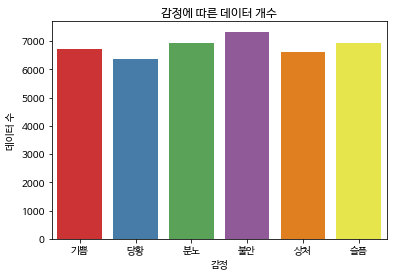

In [14]:
# 라벨값에 따른 데이터 불균형 확인

sns.barplot(data=train, x=['기쁨', '당황', '분노', '불안', '상처', '슬픔'], y=train.groupby(by='label').count()['tokens_ct'], palette='Set1')
plt.title('감정에 따른 데이터 개수')
plt.xlabel('감정')
plt.ylabel('데이터 수')
plt.show();

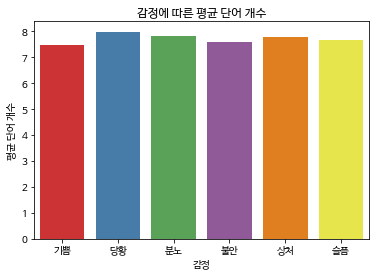

In [15]:
sns.barplot(data=train, x=['기쁨', '당황', '분노', '불안', '상처', '슬픔'], y=train.groupby(by='label').mean()['tokens_ct'], palette='Set1')
plt.title('감정에 따른 평균 단어 개수')
plt.xlabel('감정')
plt.ylabel('평균 단어 개수')
plt.show();

In [16]:
from collections import Counter

# Counter 객체는 리스트요소의 값과 요소의 갯수를 카운트 하여 저장하고 있습니다.
# 카운터 객체는 .update 메소드로 계속 업데이트 가능합니다.

def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 문서에 단어가 존재하느냐 안하느냐, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [41]:
# 개수 상위 20개 단어

wc = word_count(train['tokens'])
wc.head(20)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
35,너무,7813,7989,1.0,0.025319,0.025319,0.191125
67,친구,6740,7442,2.0,0.023586,0.048905,0.164877
53,었,3357,3495,3.0,0.011077,0.059981,0.082120
97,해서,3055,3111,4.0,0.009860,0.069841,0.074733
46,만,2718,2851,5.0,0.009036,0.078877,0.066489
0,어서,2512,2568,6.0,0.008139,0.087015,0.061450
241,회사,2192,2276,7.0,0.007213,0.094228,0.053622
107,아서,2237,2259,8.0,0.007159,0.101388,0.054722
86,오늘,2239,2246,9.0,0.007118,0.108506,0.054771
153,요즘,2203,2208,10.0,0.006998,0.115504,0.053891


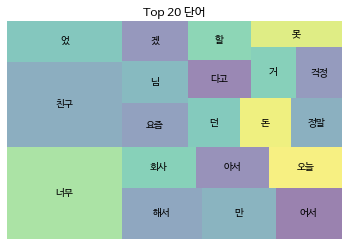

In [34]:
# 개수 상위 20개 단어 시각화

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.55)
plt.title('Top 20 단어')
plt.axis('off')
plt.show();

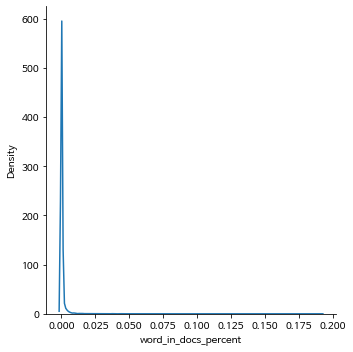

In [35]:
# 전체 문서에서 차지하는 퍼센트에 따른 밀도

sns.displot(wc['word_in_docs_percent'],kind='kde')
plt.show();

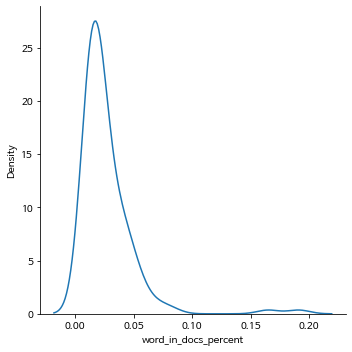

In [38]:
# 전체 문서에서 차지하는 0.01퍼센트 이상 밀도

sns.displot(wc[wc['word_in_docs_percent']>=0.01]['word_in_docs_percent'],kind='kde')
plt.show();

# 4. 벡터화(정수 인코딩)

In [39]:
train.head()

,sentence,label,tokens,tokens_ct
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 드디어, 출산, 어서, 정말, 신]",6
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]",10
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]",10
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]",12
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 드디어, 갚, 어서, 이제야, 안도감]",6


In [40]:
# 훈련, 검증 셋 분리

X_train = train['tokens']
y_train = train['label']
X_val = val['tokens']
y_val = val['label']

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 훈련셋에 대해서 tokenizer fit

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
print(tokenizer.word_index)

{'너무': 1, '친구': 2, '었': 3, '해서': 4, '만': 5, '어서': 6, '회사': 7, '아서': 8, '오늘': 9, '요즘': 10, '님': 11, '겠': 12, '던': 13, '돈': 14, '정말': 15, '다고': 16, '할': 17, '거': 18, '걱정': 19, '못': 20, '스러워': 21, '아내': 22, '건강': 23, '한테': 24, '남편': 25, '니': 26, '화': 27, '힘들': 28, '결혼': 29, '서': 30, '라고': 31, '많이': 32, '직장': 33, '기분': 34, '돼': 35, '마음': 36, '학교': 37, '아들': 38, '엄마': 39, '당황': 40, '준비': 41, '해야': 42, '슬퍼': 43, '먹': 44, '불안': 45, '랑': 46, '나이': 47, '남자': 48, '짜증': 49, '자식': 50, '부모': 51, '이제': 52, '가족': 53, '자꾸': 54, '취업': 55, '인데': 56, '난': 57, '날': 58, '걸': 59, '대': 60, '다는': 61, '딸': 62, '인': 63, '애': 64, '노후': 65, '싫': 66, '보다': 67, '병원': 68, '은퇴': 69, '공부': 70, '갑자기': 71, '어제': 72, '다니': 73, '몸': 74, '기뻐': 75, '면서': 76, '됐': 77, '아빠': 78, '줄': 79, '죽': 80, '아직': 81, '스트레스': 82, '더니': 83, '속상해': 84, '상사': 85, '업무': 86, '달': 87, '왔': 88, '연락': 89, '라': 90, '아무': 91, '성적': 92, '시험': 93, '갔': 94, '계속': 95, '남': 96, '다가': 97, '병': 98, '할지': 99, '선생': 100, '된': 101, '는지': 102, '려고': 103, '만나

In [44]:
tokenizer.word_counts

OrderedDict([('아내', 1728),
             ('드디어', 315),
             ('출산', 223),
             ('어서', 2568),
             ('정말', 1887),
             ('신', 196),
             ('당뇨', 181),
             ('랑', 1014),
             ('합병증', 46),
             ('먹', 1026),
             ('어야', 198),
             ('할', 1829),
             ('약', 214),
             ('열', 139),
             ('넘어가', 24),
             ('스트레스', 632),
             ('고등학교', 107),
             ('올라오', 11),
             ('니', 1551),
             ('중학교', 31),
             ('보다', 769),
             ('수업', 101),
             ('갑자기', 688),
             ('어려워져서', 20),
             ('당황', 1069),
             ('스러워', 1746),
             ('재취업', 24),
             ('돼서', 380),
             ('된', 540),
             ('첫', 94),
             ('월급', 116),
             ('온', 175),
             ('가족', 951),
             ('외식', 42),
             ('예정', 34),
             ('너무', 7989),
             ('행복', 259),
             ('빚', 108),
       

In [45]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 전체 훈련데이터 단어 수(단어 종류의 개수)
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 수 총합(단어 종류 별 각각의 개수 총합)
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총합

# 각 단어와 단어 별 등장 개수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq += value

    # 단어의 등장 빈도수가 threshold보다 작은 경우(즉, 여기서는 등장 횟수가 1개인 단어의 갯수)
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print('총 단어 개수 :',total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}') # 1번 이하
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12149
등장 빈도가 1번 이하인 희귀 단어의 수: 4201
단어 집합에서 희귀 단어의 비율: 34.578977693637334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3314064228237479


In [46]:
# 전체 단어 개수 중 빈도수 1개 인 단어는 제거
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7949


In [47]:
# 빈도수 1개인 단어 제거, 즉 빈도수 2개 이상인 단어들만 학습

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [48]:
print(X_train[:3])

[[22, 170, 246, 6, 15, 284], [313, 46, 989, 44, 280, 17, 258, 412, 1558, 82], [528, 2549, 26, 1318, 67, 560, 71, 1745, 40, 21]]


In [49]:
y_train = np.array(train['label'])
y_val = np.array(val['label'])

In [53]:
# 빈도수 1 이하인 단어 제거 후, 문장 자체가 사라진 경우

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [54]:
# 사라진 sentence 제거

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

40865
40865


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


토큰화된 문장의 최대 길이 : 39
토큰화된 문장의 평균 길이 : 7.6184999388229535


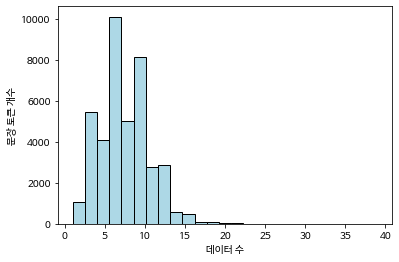

In [63]:
import matplotlib.pyplot as plt

print('토큰화된 문장의 최대 길이 :',max(len(tokens) for tokens in X_train))
print('토큰화된 문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(tokens) for tokens in X_train], bins=25, color='lightblue', edgecolor='k')
plt.xlabel('데이터 수')
plt.ylabel('문장 토큰 개수')
plt.show();

In [64]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {(count / len(nested_list))*100}')

In [70]:
max_len = 13
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 13 이하인 샘플의 비율: 96.73803988743424


In [71]:
# 13개에 맞춰 padding, 이 때 문장에서 사람의 감정은 후반에 있을 것으로 기대하여 padding='pre'로 진행

X_train = pad_sequences(X_train, maxlen=max_len, padding='pre')
X_val = pad_sequences(X_val, maxlen=max_len, padding='pre')

In [72]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,  22, 170, 246,   6,  15, 284],
      dtype=int32)

# 5. 모델링 및 훈련

In [74]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

Epoch 1/15
1278/1278 [==============================] - ETA: 0s - loss: 1.2410 - acc: 0.5407
Epoch 1: val_acc improved from -inf to 0.58519, saving model to best_model.h5
1278/1278 [==============================] - 62s 45ms/step - loss: 1.2410 - acc: 0.5407 - val_loss: 1.1391 - val_acc: 0.5852
Epoch 2/15
1278/1278 [==============================] - ETA: 0s - loss: 1.0543 - acc: 0.6194
Epoch 2: val_acc improved from 0.58519 to 0.60175, saving model to best_model.h5
1278/1278 [==============================] - 57s 44ms/step - loss: 1.0543 - acc: 0.6194 - val_loss: 1.1061 - val_acc: 0.6018
Epoch 3/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0021 - acc: 0.6403
Epoch 3: val_acc improved from 0.60175 to 0.60741, saving model to best_model.h5
1278/1278 [==============================] - 57s 45ms/step - loss: 1.0021 - acc: 0.6403 - val_loss: 1.1036 - val_acc: 0.6074
Epoch 4/15
1278/1278 [==============================] - ETA: 0s - loss: 0.9641 - acc: 0.6574
Epoch 4: val_

In [75]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

161/161 [==============================] - 1s 5ms/step - loss: 1.1036 - acc: 0.6074

 테스트 정확도: 0.6074


In [78]:
embedding_dim = 100
hidden_units = 128

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(GRU(hidden_units, dropout=0.2, recurrent_dropout=0.2)) 
model2.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

Epoch 1/15
1278/1278 [==============================] - ETA: 0s - loss: 1.2213 - acc: 0.5531
Epoch 1: val_acc improved from -inf to 0.59318, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5
1278/1278 [==============================] - 54s 41ms/step - loss: 1.2213 - acc: 0.5531 - val_loss: 1.1239 - val_acc: 0.5932
Epoch 2/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0578 - acc: 0.6173
Epoch 2: val_acc improved from 0.59318 to 0.60195, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5
1278/1278 [==============================] - 52s 41ms/step - loss: 1.0577 - acc: 0.6173 - val_loss: 1.1004 - val_acc: 0.6019
Epoch 3/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0067 - acc: 0.6378
Epoch 3: val_acc improved from 0.60195 to 0.60429, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5
1278/1278 [==============================] - 51s 40ms/

In [79]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

161/161 [==============================] - 1s 5ms/step - loss: 1.0959 - acc: 0.6043

 테스트 정확도: 0.6043


In [83]:
embedding_dim = 100
hidden_units = 128

model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim))
model3.add(GlobalAveragePooling1D()) 
model3.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model3.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

Epoch 1/15
1264/1278 [============================>.] - ETA: 0s - loss: 1.4845 - acc: 0.5051
Epoch 1: val_acc improved from -inf to 0.56257, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5
1278/1278 [==============================] - 4s 3ms/step - loss: 1.4825 - acc: 0.5049 - val_loss: 1.2287 - val_acc: 0.5626
Epoch 2/15
1278/1278 [==============================] - ETA: 0s - loss: 1.1226 - acc: 0.6023
Epoch 2: val_acc improved from 0.56257 to 0.58811, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5
1278/1278 [==============================] - 3s 3ms/step - loss: 1.1226 - acc: 0.6023 - val_loss: 1.1455 - val_acc: 0.5881
Epoch 3/15
1273/1278 [============================>.] - ETA: 0s - loss: 1.0602 - acc: 0.6240
Epoch 3: val_acc improved from 0.58811 to 0.59220, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5
1278/1278 [==============================] - 3s 3ms/step -

In [84]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

161/161 [==============================] - 0s 2ms/step - loss: 1.1304 - acc: 0.5981

 테스트 정확도: 0.5981


In [210]:
model.predict(X_val[[0]])

array([[0.12850644, 0.1710482 , 0.20819719, 0.17323917, 0.17765547,
        0.14135346]], dtype=float32)

# 3. 벡터화(Vectorize) 분산 표현의 한계를 알고 일단은 횟수기반으로 해볼 예정
- Word2Vec
- Glove
- FastText

In [4]:
# 벡터화하기에 앞서 전처리를 위해 concat하였던 train set, val set을 다시 나눠주기

train_count = 40879

In [5]:
df_train = df.iloc[:train_count, :]
df_val = df.iloc[train_count:, :]

In [ ]:
print(df_train.shape, df_val.shape)

(40879, 3) (5130, 3)


리뷰의 최대 길이 : 39
리뷰의 평균 길이 : 7.71865750140659


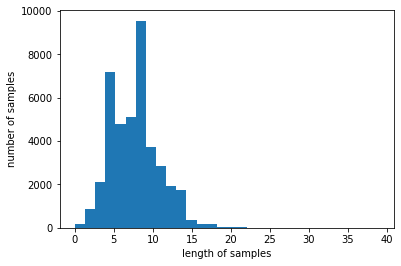

In [ ]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(sentence) for sentence in df_train['sentence_tokenized']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['sentence_tokenized']))/len(df_train['sentence_tokenized']))
plt.hist([len(sentence) for sentence in df_train['sentence_tokenized']], bins=30)
plt.xlabel('length of samples');
plt.ylabel('number of samples');
plt.show();

In [6]:
# 각 sentence 별 토큰 갯수

df_train['count_token'] = [len(x) for x in df_train['sentence_tokenized']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_train.head()

,sentence,label,sentence_tokenized,count_token
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 드디어, 출산, 어서, 정말, 신]",6
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]",10
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]",10
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]",12
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 드디어, 갚, 어서, 이제야, 안도감]",6


In [ ]:
# 각 감정 별 평균 토큰의 갯수 차이는 크게 나지 않음

df_train.groupby(by='label').sum()['count_token'] / df_train.groupby(by='label').count()['sentence']

label
0    7.478235
1    7.988050
2    7.832803
3    7.574840
4    7.782458
5    7.681996
dtype: float64

In [7]:
df_train.head()

,sentence,label,sentence_tokenized,count_token
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 드디어, 출산, 어서, 정말, 신]",6
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]",10
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]",10
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]",12
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 드디어, 갚, 어서, 이제야, 안도감]",6


## 3-1. Word2Vec(분산 표현의 한계를 알고 일단은 횟수기반으로 해볼 예정)

In [119]:
from gensim.models import FastText

ft_model = FastText(sentences=df_train['sentence_tokenized'], size=100, window=5, min_count=0, workers=4, sg=0)

In [120]:
for i in ft_model.wv.vocab:
    print(i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
구분
오토바이
옆방
등갈비
특정
주무르
잔반
축소
기승
들어올리기
접대
적당히
지나칠
코코아
음미
몰라도
스쳐도
따가워서
도리어
이러다
간수
치가
을수록
부여
냄새나
기에
치웠
빨개져
연극배우
오디션
배역
환호
쫄딱
망할
재택
특수
부대
만난다니
정성껏
맨
경운기
바친
수련
과식
부룩
자매
들려주
일관
작심삼일
사시사철
점차
참으로
세금
거둬들여
기저
지소
뻗
커뮤니티
궁색
투
제작
내려버렸
미옥
올바르
입찰가
잡혀서
알아맞혀서
간다던
더라는
와선
평상시
어려워졌
알려준
기역
지끈지끈
설탕
소금
충동
심장병
들러서
빅
히트
방탄
소년단
들려
선산
묻혀
게끔
큰처남
울컥
지정
깔끔
적절
능률
사죄
비대
편한지
헤어질까
허가
나갈지
와이셔츠
립스틱
곗거리는
어두우
중압감
나을지
미끄러지
설문
냉혹
지켜준
연달
당해야
글
서슴
무지
페인트칠
유력
보유
말썽
일으키
권위
과제물
들여가
유라
농담
보채
쯕
재단
시원찮
안면
극도
짓궂
라잖아
오줌
큰소리
떵떵
드러날까
언급
서기
기다려줄
연주
오르간
반주자
갑작스러운
전역
야자
메꿀
최우선
패거리
쫄면
친할머니
우시
고달플
위염
내려온다
가로
괜한
못했을까
번번이
자던
끄떡
조리
대견
자국
보호사
창립
마마
무가
다닌다면서
데려
배당
단다
새우
올라올
살아났
마찬가지
유난히
꿋꿋
견뎌낼
베트남
꾸려왔
숨겨버렸
입국
확
벅차
송년회
경품
내게도
성폭행
수감
예보
갑상샘
쌈짓돈
버텨
고달프
뛰어놀
놀랐었
인파
연고
손녀딸
지킨다는
당했었
마늘
휘말렸
이겨낼
가뜩이나
더운데
어깨치기
나타났
공책
경쟁
더더욱
창창
됐으니
공모전
관해선
잃어버려서
떠미
치수
달랑
으냐고
외국인
진땀
뺐
파손
얄미워서
자면서
클
닥치
번졌
내세울
해지지
내버렸
바라보
제쳐
툴툴거리
반신불수
음반
남용
기다려도
젤
사귈까
터질
발리
국비
훌륭
떠나가
스마트폰
상해도
비아냥대
치료법
헤드셋
배고파도
세미나
콩쿠르
거북
여보
해져야
얌전히
간경변
상가
결코
날까봐
오질
학용품
유치
자립


In [121]:
import numpy as np

def ft_oov_clear(x):
    temp = []
    for i in x:
        if i in ft_model.wv.vocab:
            temp.append(ft_model.wv.get_vector(i))
        else:
            temp.append(np.zeros(100))
    return temp

In [122]:
df_train['token_ft'] = df_train['sentence_tokenized'].apply(ft_oov_clear)
df_val['token_ft'] = df_val['sentence_tokenized'].apply(ft_oov_clear)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [123]:
df_train['emb_sum'] = df_train['token_ft'].apply(lambda x : sum(x))
df_val['emb_sum'] = df_val['token_ft'].apply(lambda x : sum(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [124]:
df_train.head()

,sentence,label,sentence_tokenized,token_ft,emb_sum
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 드디어, 출산, 어서, 정말, 신]","[[-0.47908238, 0.10452405, -0.61135834, -0.086...","[-2.7622643, 2.5919623, -3.7141917, -0.428154,..."
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]","[[-0.18983702, 0.08445579, 0.09581239, -0.0363...","[-4.539967, 4.4898887, -2.4631171, -0.5677744,..."
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]","[[-0.3473927, 0.27916664, -0.5327369, -0.16421...","[-3.6469052, 3.8807096, -3.48676, -1.3412272, ..."
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]","[[-0.0906374, 0.3887145, -0.19796923, -0.06619...","[-4.035228, 5.191595, -4.471341, -0.18273228, ..."
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 드디어, 갚, 어서, 이제야, 안도감]","[[-0.35850596, 0.2684549, -0.46937126, -0.0437...","[-2.118325, 1.7161527, -2.7382817, -0.16137761..."


In [130]:
X_train = np.array(df_train['emb_sum'])
y_train = np.array(df_train['label'])

In [131]:
X_train[0]

array([-2.7622643 ,  2.5919623 , -3.7141917 , -0.428154  , -0.64402944,
        0.9530391 , -5.4376636 , -1.068436  , -5.8607435 ,  0.07391755,
        2.732811  , -0.9195727 , -1.3625448 , -2.4824712 ,  3.118587  ,
        0.525766  ,  2.7694023 ,  2.0849776 ,  3.3380005 ,  0.5648266 ,
       -1.1761781 , -0.97281975, -1.4841338 ,  2.5744538 , -2.3207643 ,
        0.5392727 ,  0.6758279 ,  0.02066005, -2.288469  ,  1.7115164 ,
       -0.21465224, -2.1138334 , -1.2664555 , -2.9272342 ,  3.1557617 ,
        2.0385878 ,  3.921784  , -2.2883358 ,  0.6545327 ,  3.3113446 ,
        3.0633745 , -0.7544361 , -3.8105776 ,  1.709759  , -0.1166988 ,
        2.3448398 ,  0.08120473,  2.907869  , -4.852278  , -0.89180875,
       -5.56003   , -2.068175  , -1.9925092 , -1.380685  ,  0.20400389,
       -0.2155325 , -2.8856719 , -1.1383297 ,  3.8011549 , -2.6288722 ,
       -1.8631392 ,  5.3682613 , -2.3292334 , -1.4744557 ,  3.9286575 ,
       -3.2351775 , -1.7078991 ,  2.910611  ,  3.9626665 ,  0.44

In [127]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))

In [128]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [132]:
history = model.fit(X_train, y_train, epochs=3)

ValueError: ignored

In [34]:
X_train[0]

array([-2.7385552 ,  2.244759  , -3.1159198 , -0.60987777, -0.55548584,
        0.4847871 , -5.490365  , -0.98703754, -6.6856728 ,  0.42798936,
        2.3296824 , -0.74118906, -1.4821255 , -3.2078798 ,  3.1712883 ,
        0.5320345 ,  2.1059146 ,  2.4038124 ,  3.4729414 ,  0.23692288,
       -1.7194679 , -1.0931963 , -1.4497373 ,  3.0854383 , -1.8759593 ,
        0.4495644 ,  1.1165814 ,  0.42243913, -2.4884386 ,  1.7622197 ,
       -0.5579253 , -2.22273   , -1.819586  , -2.8027391 ,  3.0341265 ,
        1.7594432 ,  3.867857  , -3.159195  ,  0.32479224,  2.9938698 ,
        3.1298938 , -0.9405995 , -3.969591  ,  1.5952805 , -0.15668765,
        2.8649585 , -0.12728885,  2.902737  , -4.9352894 , -1.1968001 ,
       -5.24426   , -1.5201328 , -1.9302652 , -0.7738881 ,  0.06692669,
       -0.24476826, -1.9516613 , -1.17682   ,  3.670167  , -2.5554943 ,
       -1.6605066 ,  5.4832935 , -1.8365206 , -1.1901344 ,  3.87534   ,
       -3.3738046 , -1.2123331 ,  2.1059444 ,  3.040809  ,  0.74